# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

###  Загрузим библиотеки и скачаем датасеты

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgbm
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, cv, train
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [ ]:
try:
    data = pd.read_csv('/datasets/autos.csv')   
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

###  Посмотрим общую информацию про датасет

In [4]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


### Удалим ненужные столбцы

В столбце 'NumberOfPictures' все значения - это 0. Другие столбцы просто нам не нужны для дальнейшего обучения моделей. 

In [8]:
data = data.drop(columns=['DateCrawled', 'Model',
                 'RegistrationMonth', 'DateCreated', 
                 'LastSeen', 'NumberOfPictures'], axis=1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Kilometer         354369 non-null  int64 
 6   FuelType          321474 non-null  object
 7   Brand             354369 non-null  object
 8   Repaired          283215 non-null  object
 9   PostalCode        354369 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 27.0+ MB


### Удалим аномальные значения в столбце Price

Значения меньше 10 скорее всего являются ошибочными, поэтому их стоит удалить

In [9]:
data = data.loc[data['Price'] >= 10 ]

### Удлаим аномальные значения столбца Power

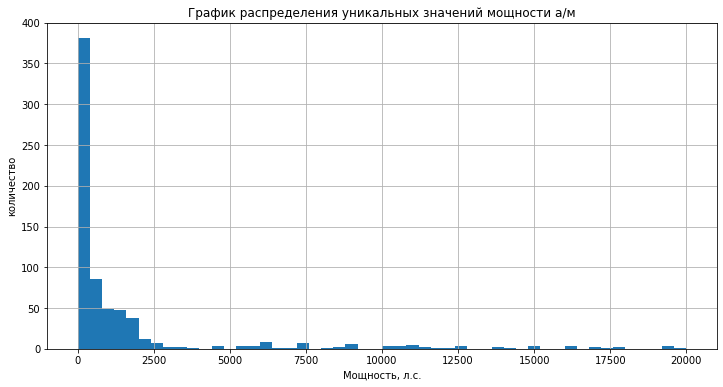

In [10]:
pd.Series(list(data.Power.unique())).sort_values(ascending=False).plot(kind='hist', figsize=(12,6), grid=True, bins=50)
plt.title('График распределения уникальных значений мощности а/м')
plt.ylabel('количество')
plt.xlabel('Мощность, л.с.')
plt.show()

In [11]:
data=data.query('Power > 15 & Power < 1600')

### Удалим ненужные значения в столбце RegistrationYear 

In [12]:
data = data.query('RegistrationYear >= 1950 & RegistrationYear < 2018')

### Заполним пропущенные значения категориальных признаков заглушкой

In [13]:
data = data.fillna('unknown')

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303089 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             303089 non-null  int64 
 1   VehicleType       303089 non-null  object
 2   RegistrationYear  303089 non-null  int64 
 3   Gearbox           303089 non-null  object
 4   Power             303089 non-null  int64 
 5   Kilometer         303089 non-null  int64 
 6   FuelType          303089 non-null  object
 7   Brand             303089 non-null  object
 8   Repaired          303089 non-null  object
 9   PostalCode        303089 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 25.4+ MB


### Добавим столбец разделение машин по возрастам

In [15]:
k=[]
for i in data['RegistrationYear']:
    if i <= 1980:
        s_old='Super Retro'
        k.append(s_old)
    if i > 1980 and i <= 2000:
        retro='Retro'
        k.append(retro)
    if i > 2000 and i <= 2012:
        old='Old'
        k.append(old)
    if i > 2012:
        new='New'
        k.append(new)
data['AgeType']=k

### Разделим выборки на features и target

In [16]:
target = data[['Price']]
features = data.drop(['Price'], axis=1)

### Определим тестовую, валидационную и тренировочную выбрки

In [17]:
features_80, features_test, target_80, target_test = train_test_split(
    features, target, test_size=.2, random_state=12345)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_80, target_80, test_size=.25, random_state=12345)

### Применим OrdinalEncoder для категориальных признаков

Обозначим категориальные признаки

In [18]:
cat_features = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired', 'AgeType']

Преобразуем категориальные признаки в численные с помощью техники порядкового кодирования OE

In [19]:
encoder = OrdinalEncoder()
encoder.fit(features_train[cat_features])
features_train[cat_features]= encoder.transform(features_train[cat_features])
features_valid[cat_features]= encoder.transform(features_valid[cat_features])
features_test[cat_features]= encoder.transform(features_test[cat_features])
features_80[cat_features]= encoder.transform(features_80[cat_features])

**Вывод**

- Удалены признаки, которые не помогут в исследовании:
    - DateCrawled — дата скачивания анкеты из базы
    - Model — модель автомобиля
    - RegistrationMonth — месяц регистрации автомобиля
    - DateCreated — дата создания анкеты
    - LastSeen — дата последней активности пользователя
    - NumberOfPictures - количество фотографий автомобиля (здесь сохранены только нули)
- Удалены аномальные значения в целевом признаке
- Пропусков в количественных признаках нет
- Пропуски в категориальных признаках заменены заглушкой
- Категориальные признаки преобразованы в численные
- Данные подготовлены к проведению исследования

## Обучение моделей

### Для понимания, какие факторы важны при моделировании, создадим функцию, используя feature_importances_

In [20]:
def importances(model,features):
    features = features.columns
    importances = model.feature_importances_
    indices = np.argsort(importances)
    
    plt.figure(figsize=(11, 5))
    plt.title('Важность функции')
    plt.barh(range(len(indices)), importances[indices], color='#6495ED', align='center')
    plt.yticks(range(len(indices)), features[indices])
    plt.xlabel('Относительная важность')
    plt.show()
        
    feat_importances = pd.Series(importances, index=features).sort_values(ascending=False)
    feat_importances = feat_importances.to_frame()
    feat_importances.columns=['Относительная важность']
    display(feat_importances)

### Градиентный бустинг LightGBM

In [21]:
%%time
start = time.time()
model_LGB = lgbm.sklearn.LGBMRegressor(n_estimators=1000, random_state=123, learning_rate=0.4, objective='rmse')
model_LGB.fit(features_train, target_train, eval_set=(features_valid, target_valid), verbose=100)
end = time.time()
t_lgb=round(end-start,2)

[100]	valid_0's rmse: 1664.2
[200]	valid_0's rmse: 1637.52
[300]	valid_0's rmse: 1629.02
[400]	valid_0's rmse: 1626.15
[500]	valid_0's rmse: 1626.26
[600]	valid_0's rmse: 1625.07
[700]	valid_0's rmse: 1626.31
[800]	valid_0's rmse: 1625.01
[900]	valid_0's rmse: 1625.94
[1000]	valid_0's rmse: 1626.98
CPU times: user 31.2 s, sys: 0 ns, total: 31.2 s
Wall time: 31.4 s


In [22]:
%%time
start = time.time()
predict_LGB= model_LGB.predict(features_valid)
end = time.time()
t_lgb_p=round(end-start,2)

((mean_squared_error(target_valid, predict_LGB))**0.5).round(2)

CPU times: user 4.7 s, sys: 0 ns, total: 4.7 s
Wall time: 4.73 s


1626.98

#### Факторы важности модели LightGBM

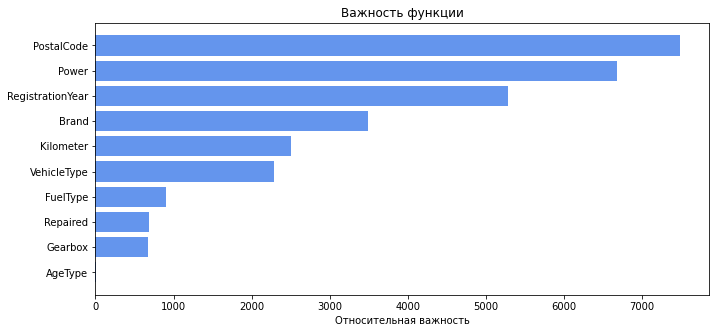

,Относительная важность
PostalCode,7485
Power,6684
RegistrationYear,5283
Brand,3495
Kilometer,2508
VehicleType,2284
FuelType,905
Repaired,682
Gearbox,672
AgeType,2


In [23]:
importances(model_LGB, features_train)

### Градиентный бустинг CatBoost

In [24]:
%%time
start = time.time()
model_cat = CatBoostRegressor(random_state=123, learning_rate=0.4, verbose=100,n_estimators=1000)
model_cat.fit(features_train, target_train, eval_set=(features_valid, target_valid))
end = time.time()
t_cat=round(end-start,2)

0:	learn: 3530.7031830	test: 3500.4653626	best: 3500.4653626 (0)	total: 81ms	remaining: 1m 20s
100:	learn: 1674.3733261	test: 1708.0770859	best: 1708.0770859 (100)	total: 2.75s	remaining: 24.4s
200:	learn: 1593.8531765	test: 1667.1666327	best: 1667.1666327 (200)	total: 5.48s	remaining: 21.8s
300:	learn: 1547.3300978	test: 1647.6185899	best: 1647.6185899 (300)	total: 8.07s	remaining: 18.7s
400:	learn: 1512.7258717	test: 1637.5779769	best: 1637.5676629 (398)	total: 10.7s	remaining: 16s
500:	learn: 1485.5736727	test: 1629.5836570	best: 1629.5836570 (500)	total: 13.3s	remaining: 13.3s
600:	learn: 1460.5702277	test: 1625.0062959	best: 1624.8473815 (591)	total: 15.9s	remaining: 10.6s
700:	learn: 1440.1707397	test: 1620.8729314	best: 1620.8729314 (700)	total: 18.6s	remaining: 7.93s
800:	learn: 1423.4587984	test: 1617.9885728	best: 1617.9086968 (798)	total: 21.2s	remaining: 5.26s
900:	learn: 1407.8921940	test: 1615.8848012	best: 1615.8848012 (900)	total: 23.8s	remaining: 2.61s
999:	learn: 1393

In [25]:
%%time
start = time.time()
predict_cat = model_cat.predict(features_valid)
end = time.time()
t_cat_p = round(end-start,2)

((mean_squared_error(target_valid, predict_cat))**0.5).round(2)

CPU times: user 67.8 ms, sys: 394 µs, total: 68.2 ms
Wall time: 66.2 ms


1614.4

#### Факторы важности модели CatBoost

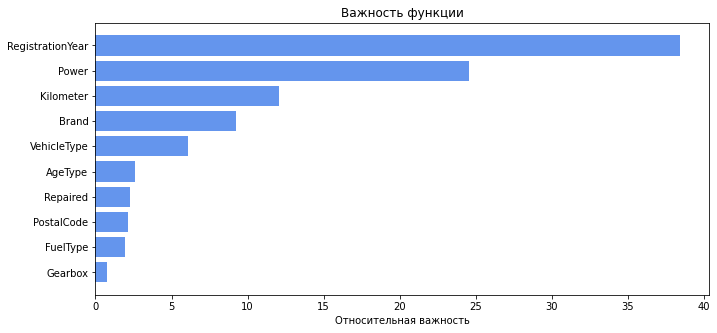

,Относительная важность
RegistrationYear,38.426956
Power,24.545052
Kilometer,12.040988
Brand,9.270800
VehicleType,6.067188
AgeType,2.576709
Repaired,2.282644
PostalCode,2.112620
FuelType,1.944333
Gearbox,0.732710


In [26]:
importances(model_cat, features_train)

### Модель RandomForestRegressor

In [27]:
%%time
start = time.time()
model_rf = RandomForestRegressor(random_state=12345, criterion='mse',warm_start=False, n_estimators=100)
model_rf.fit(features_train, target_train)
end = time.time()
t_rf = round(end-start,2)

CPU times: user 1min 3s, sys: 1.29 s, total: 1min 4s
Wall time: 1min 4s


In [28]:
%%time
start = time.time()
pred_rf=model_rf.predict(features_valid)
end = time.time()
t_rf_p = round(end-start,2)

((mean_squared_error(target_valid, pred_rf))**0.5).round(2)

CPU times: user 3.2 s, sys: 12.3 ms, total: 3.21 s
Wall time: 3.22 s


1640.11

#### Факторы важности модели RandomForestRegressor

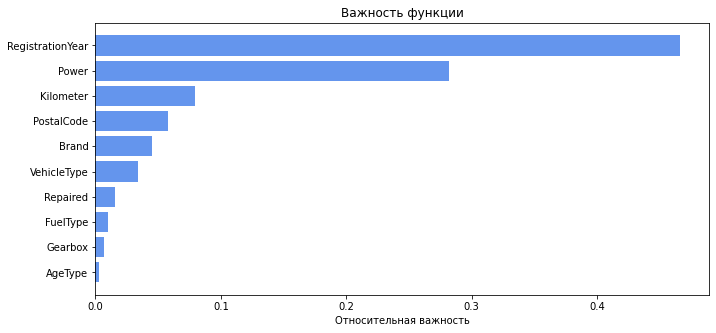

,Относительная важность
RegistrationYear,0.466237
Power,0.281772
Kilometer,0.079561
PostalCode,0.058145
Brand,0.044939
VehicleType,0.034008
Repaired,0.015318
FuelType,0.009926
Gearbox,0.007007
AgeType,0.003087


In [29]:
importances(model_rf, features_train)

**Вывод**

Показатели RMSE:
- Результат LightGBM - 1627
- Результат CatBoost - 1614
- Результат RandomForestRegressor - 1640

Показатели времени:
- LightGBM: fit - 3min 19s, predict - 5 s                  
- CatBoost: fit - 27 s, predict - 68 ms     
- RandomForestRegressor: fit - 1min 3s, predict - 3 s
                        
Факторы важности:
- LightGBM  --  PostalCode	
- CatBoost  --  RegistrationYear
- RandomForestRegressor  --  RegistrationYear

Из полученных результатов видно, что лучшей моделью является CatBoost. Её мы и будет использовать на тестовой выборке.

## Проверка лучшей модели на тестовой выборке

In [30]:
model_cat = CatBoostRegressor(random_state=12345, learning_rate=0.4, verbose=100, n_estimators=1000)
model_cat.fit(features_train, target_train, eval_set=(features_test, target_test))
predict_cat = model_cat.predict(features_test)
mean_squared_error(target_test, predict_cat) ** .5

0:	learn: 3520.9770632	test: 3510.8633700	best: 3510.8633700 (0)	total: 26.2ms	remaining: 26.2s
100:	learn: 1670.9011627	test: 1695.5620824	best: 1695.5620824 (100)	total: 2.65s	remaining: 23.6s
200:	learn: 1592.4849352	test: 1653.0801177	best: 1653.0801177 (200)	total: 5.33s	remaining: 21.2s
300:	learn: 1546.3366771	test: 1633.0667665	best: 1632.9713973 (298)	total: 7.99s	remaining: 18.6s
400:	learn: 1512.8616873	test: 1622.7309032	best: 1622.7021488 (399)	total: 10.7s	remaining: 15.9s
500:	learn: 1486.1079203	test: 1616.6340265	best: 1616.5150125 (494)	total: 13.1s	remaining: 13.1s
600:	learn: 1462.2942593	test: 1610.0350520	best: 1610.0350520 (600)	total: 15.5s	remaining: 10.3s
700:	learn: 1441.6999461	test: 1606.3131162	best: 1606.2503634 (698)	total: 18s	remaining: 7.67s
800:	learn: 1423.7764894	test: 1603.1674505	best: 1603.1674505 (800)	total: 20.5s	remaining: 5.08s
900:	learn: 1407.3755970	test: 1601.6872585	best: 1601.4527568 (893)	total: 23s	remaining: 2.53s
999:	learn: 1392.

1599.514540757783

**Вывод**

Качество предсказаний, полученное на тестовой выборке удовлетворяет обозначенному условию

## Вывод

- в ходе предобработки и анализа полученных данных удалены ненужные признаки, категориальные признаки преобразованы в количественные, обработаны пропуски в признаках, удалены аномальные значения признаков
- подготовлены выборки для обучения моделей при помощи train_test_split
- обучены модели и получены такие результаты метрики RMSE:

    - Результат LightGBM - 1627
    - Результат CatBoost - 1614
    - Результат RandomForestRegressor - 1640


- время обучения и предсказания моделей:

    - LightGBM: fit - 3min 19s, predict - 5 s
    - CatBoost: fit - 27 s, predict - 68 ms
    - RandomForestRegressor: fit - 1min 3s, predict - 3 s


- общее заключение: для решения поставленной задачи наиболее подходящей моделью является *CatBoost*
- результат модели RandomForestRegressor на тестовой выборке - 1600